In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import units as u
#import xgboost as xgb
#from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.metrics import mean_squared_error
#from sklearn import metrics 
import cmasher as cmr
import glob as glob
import math
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from scipy.constants import h, c, k
from colour_system import cs_hdtv
from scipy.optimize import curve_fit

cmap=plt.cm.twilight
cmap_blue = cmr.get_sub_cmap('twilight_shifted', 0.05, 0.45)
cmap_red = cmr.get_sub_cmap('twilight', 0.5, 1)
cmap_red_cut = cmr.get_sub_cmap('twilight', 0.7, 1)

cmap_red_r = cmr.get_sub_cmap('twilight_shifted', 0.55, 0.95)

In [2]:
pyssed_files_glob='/share/nas2/ela/EXPLORE/data/ms_batch*/output_run*.dat'
pyssed_file='/share/nas2/ela/EXPLORE/data/ms_all.dat'
iso=np.loadtxt('iso3.txt')
#print(iso.shape)
logAge=np.unique(iso[:,2])
minage=np.nanmin(logAge)
maxage=np.nanmax(logAge)
agerange=maxage-minage

In [3]:
def param_update():

	plt.rcParams.update({'font.size': 10})
	plt.rcParams.update({'font.family': 'STIXGeneral'})
	plt.rcParams.update({'mathtext.fontset': 'stix'})
	pd.set_option("display.max_rows",5)
	pd.set_option("display.max_columns",None)


def glob_files(globstr):
    filelist=glob.glob(globstr)
    print("{} Files found via glob".format(len(filelist)))
    #print(filelist)
    return filelist

def combine_files(filelist):
    df_list=[]
    n=0
    for file in filelist:
        sub_df = pd.read_table(file,skiprows=1,header=[1,2,3,4,5,6,7],low_memory=False)
        print("Entries for {}: {}".format(file,len(sub_df.index) ))

        if n==0:
            running_df=sub_df
            n+=1
        else:
            running_df=pd.concat([running_df,sub_df])
    print("Done")
    df=running_df
    
    print("Processing data")
    # Extract text features
    cats = df.select_dtypes(exclude=np.number).columns.tolist()
    # Convert to Pandas category
    for col in cats:
        df[col] = df[col].astype('category')
    #force numeric columns where needed
	#can probably change this to select based on column name...
	#for col in  df.columns[21:222]:
	#    df[col] = pd.to_numeric(df[col], errors='coerce')
	#check the above worked if needed
	#for i in range(0,239):
	#    print(i,output_df.dtypes[i])
	#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    features=df.replace('[]', np.nan).replace('--', np.nan)#.select_dtypes(include=numerics)
    features.to_csv(pyssed_file,sep='\t', index=False, quoting=3,escapechar="\t",na_rep='[]',header=True)
    
    return features

def process_files(filelist):
    df_list=[]
    n=0
    n_tot=1000
    param_update()
    plt.figure(dpi=600)
    #plot isochrones
    for age in logAge:
        colour=(age-minage)/(maxage-minage)
        #print(c)
        iso_a=np.where(iso[:,2]==age,1,np.nan)
        iso_b=np.where(iso[:,6]>=-5,iso_a,np.nan) #bad iso values
        plt.plot(np.power(10,iso_b[:]*iso[:,7]),np.power(10,iso_b[:]*iso[:,6]),zorder=0,color=cmap_blue(colour),lw=0.8)
    for file in filelist[1000:n_tot+1000]:
        sub_df = pd.read_table(file,skiprows=1,header=[1,2,3,4,5,6,7],low_memory=False)
        #print(sub_df)
        #print("{}. Entries for {}: {}".format(n,file,len(sub_df.index) )) 
        n+=1
        #i=0
        #for col in sub_df.columns:
        #    i+=1
        #    print(i,col)
        ax=plt.subplot()
        ax.scatter(sub_df.iloc[:,9],sub_df.iloc[:,10],s=0.1,color='k',alpha=0.2)#,c=np.log(np.asarray(features.iloc[:,9])),cmap=plt.cm.RdYlBu,figsize = (10, 8),vmin=8,vmax=11)
        ax.set_xlabel('T_eff [K]')
        ax.set_ylabel('Lum [L_sun]')

    b=ax.scatter(logAge,logAge,c=logAge,cmap=cmap_blue)
    cbar=plt.colorbar(b,fraction=0.0475, pad=0.005)
    cbar.ax.set_ylabel('logAge')
    ax.set_xlim( [1000,50000] )
    ax.set_ylim( [0.00001,10000000] )
    plt.xscale('log')
    plt.yscale('log')

    ax.invert_xaxis()
    
    plt.show()
    #names=sub_df.iloc[:,1]
    #names=names.rename('Name')
    #features=sub_df.iloc[:,2:]
    #print(names)

def getTeffLsun(filelist):
    n=0
    x=[]
    y=[]
    for file in filelist:
        n+=1
        sub_df = pd.read_table(file,skiprows=1,header=[1,2,3,4,5,6,7],low_memory=False)
        #print(sub_df)
        print("{}. Entries for {}: {}".format(n,file,len(sub_df.index) )) 
        x.append(sub_df.iloc[:,9])
        y.append(sub_df.iloc[:,10])
    print(len(x),len(y))
    return x,y
    
def read_files(filestr):
	df = pd.read_table(filestr,skiprows=1,header=[1,2,3,4,5,6,7],low_memory=False)

def planck(T):
    """ Returns the spectral radiance of a black body at temperature T.
    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.
    """
    # The grid of visible wavelengths corresponding to the grid of colour-matching
    # functions used by the ColourSystem instance.
    lam = np.arange(380., 781., 5)
    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B


In [4]:
filelist=glob_files(pyssed_files_glob)
#process_files(filelist)
#df=combine_files(filelist)

19799 Files found via glob


In [4]:
#x,y=getTeffLsun(filelist)
xarr=np.load('x.npy')
yarr=np.load('y.npy')
logx=np.log10(xarr)
logy=np.log10(yarr)

/tmp/ipykernel_128345/4188673928.py:4: RuntimeWarning: divide by zero encountered in log10
  logx=np.log10(xarr)
/tmp/ipykernel_128345/4188673928.py:5: RuntimeWarning: divide by zero encountered in log10
  logy=np.log10(yarr)


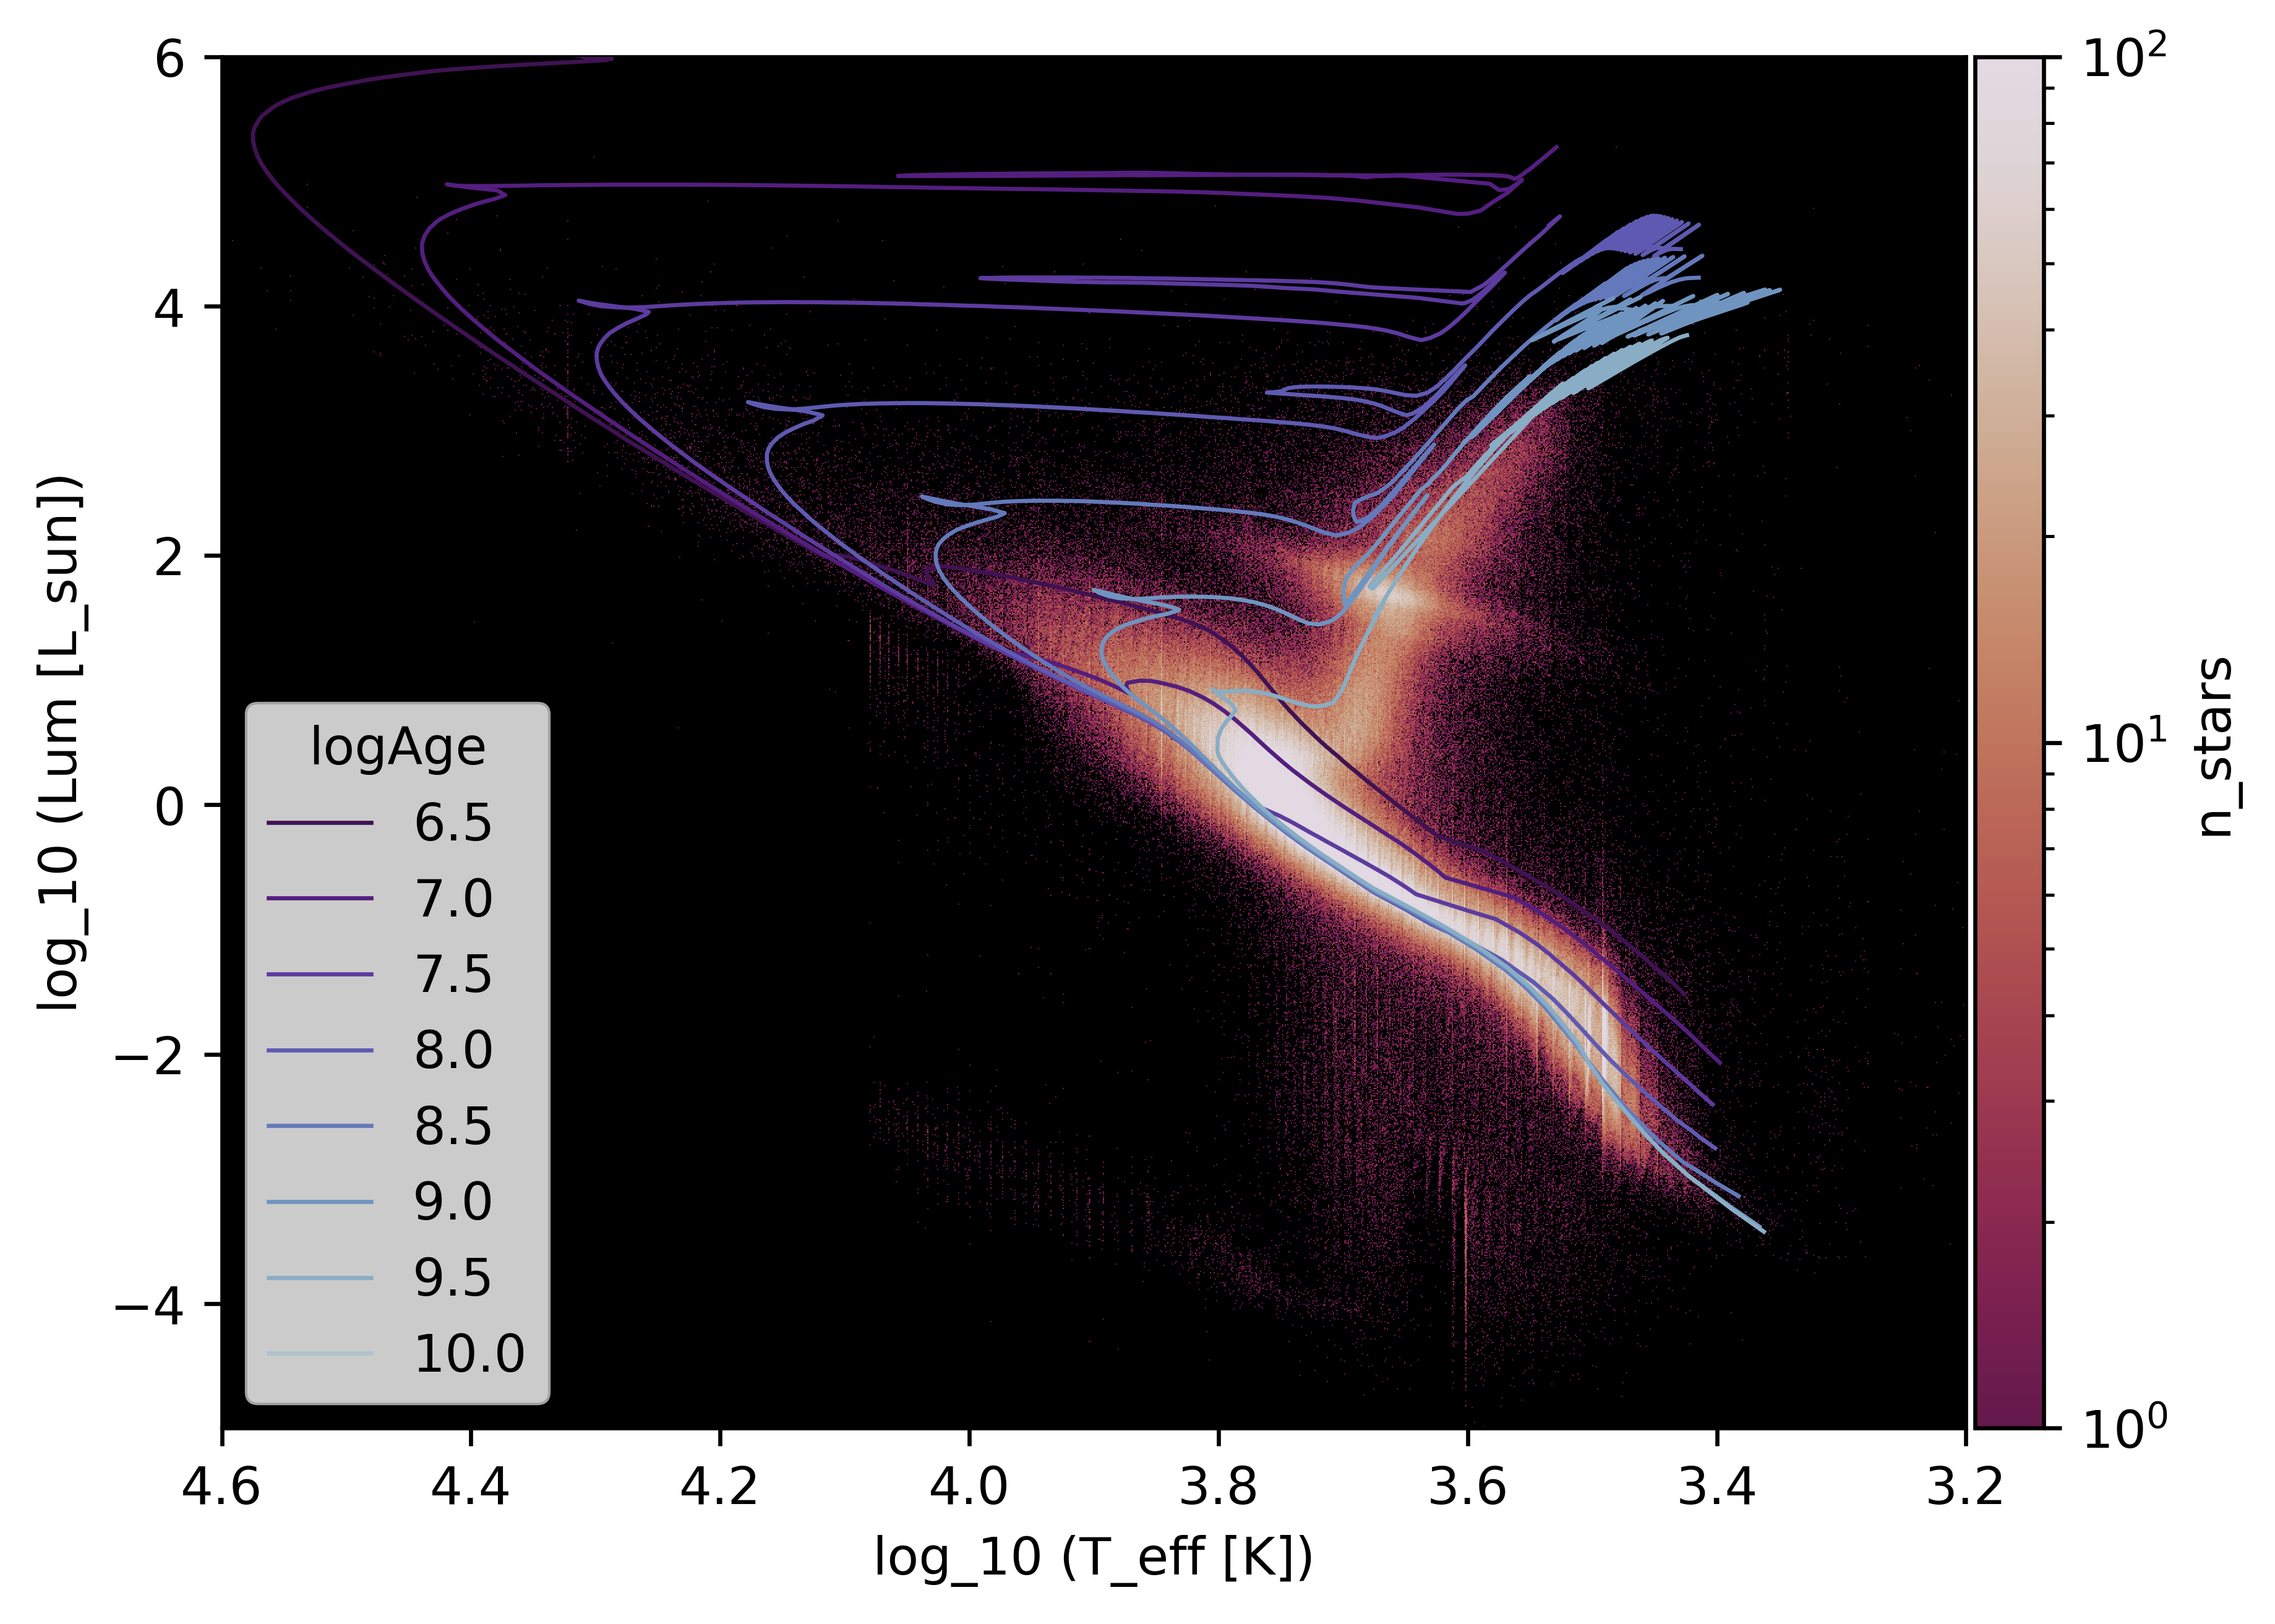

In [5]:
xmin=3.2
xmax=4.6
ymin=-5
ymax=6
nx=math.ceil((xmax-xmin)*1000) #rounding error don't know why??
ny=int((ymax-ymin)*100)
 

plt.figure(dpi=600)
plt.style.use('default')
ax=plt.subplot()
cmap_red_cut = cmr.get_sub_cmap('twilight', 0.6, 1)
counts,ybins,xbins,image=plt.hist2d(logx,logy,norm='log',range=[[xmin,xmax], [ymin,ymax]],bins=[nx,ny],cmap=cmap_red_cut,vmax=100)
ax.invert_xaxis()
ax.set_facecolor('k') 
for age in logAge:
    if age%0.5 == 0.0 or age ==10.00001:
        if age ==10.00001:
            age=10.0 #dunno why    
        color=(age-minage)/(maxage-minage)
        #print(c)
        iso_a=np.where(iso[:,2]==age,1,np.nan)
        iso_b=np.where(iso[:,6]>=-5,iso_a,np.nan) #bad iso values
        plt.plot(iso_b[:]*iso[:,7],iso_b[:]*iso[:,6],color=cmap_blue(color),lw=0.8,zorder=5,label=str(age))
plt.legend(title='logAge')

ax.set_xlabel('log_10 (T_eff [K])')
ax.set_ylabel('log_10 (Lum [L_sun])')
cbar=plt.colorbar(image,fraction=0.0475, pad=0.005)
cbar.ax.set_ylabel('n_stars')


plt.show()

<Figure size 640x480 with 0 Axes>

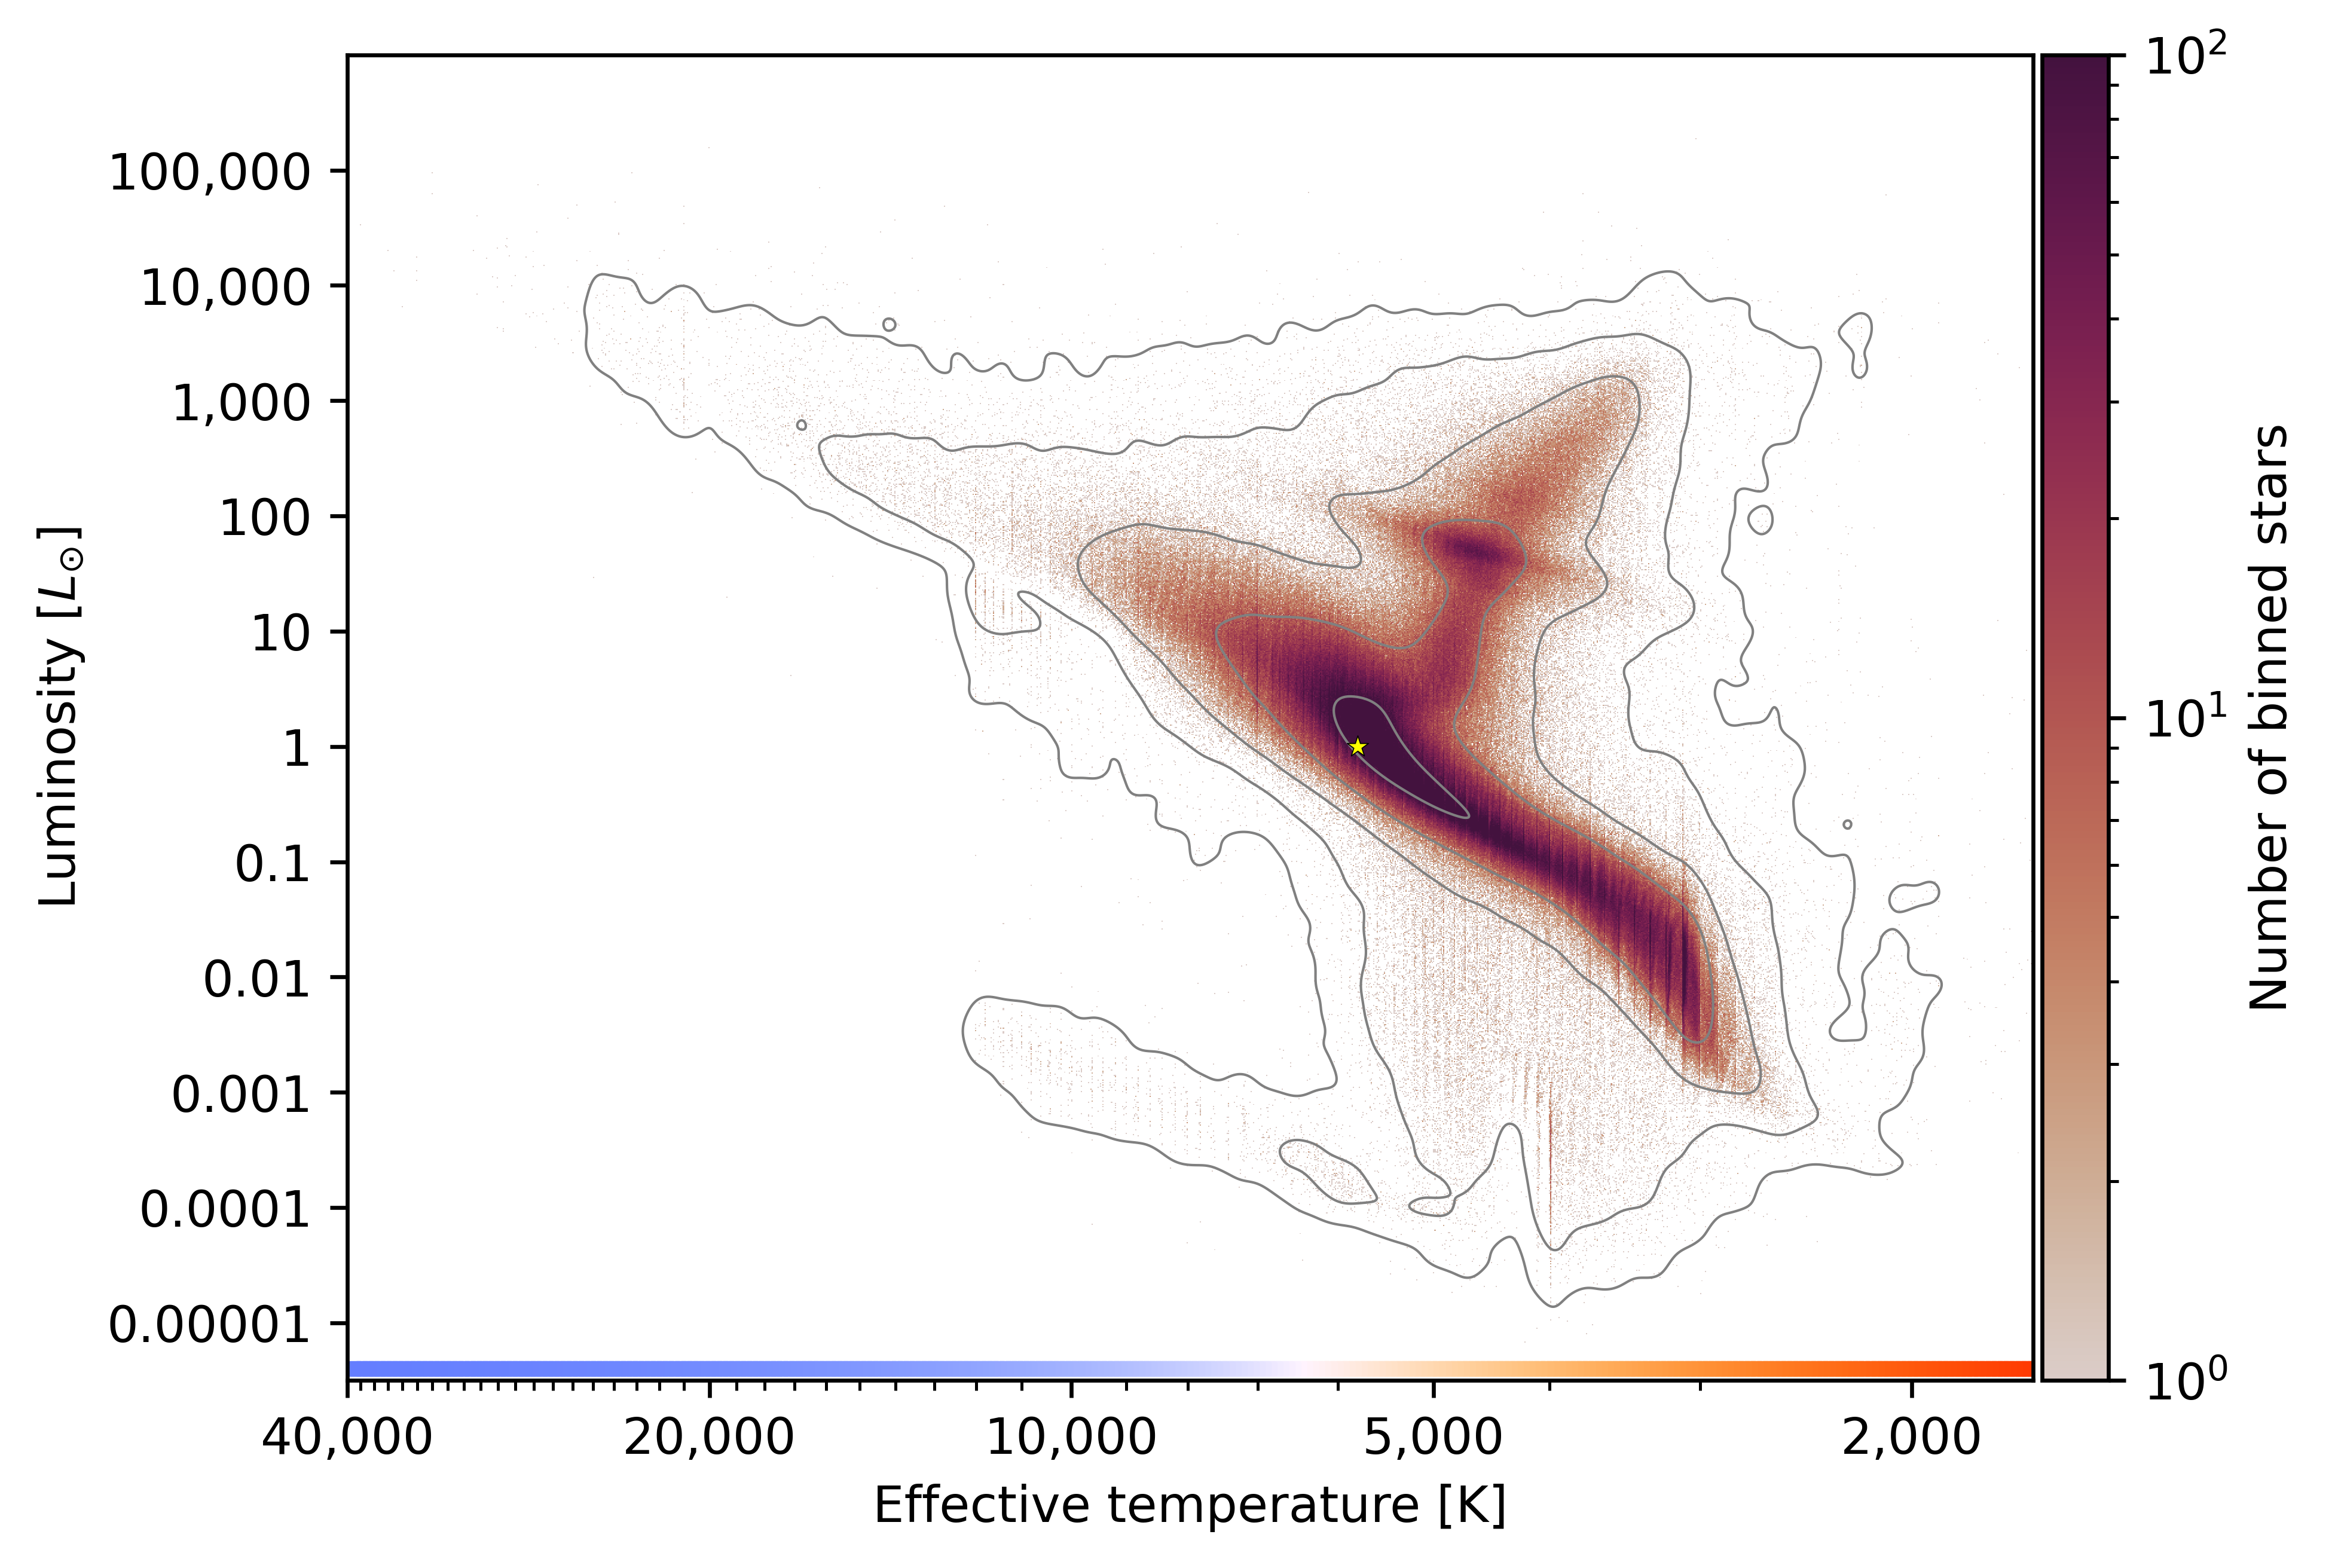

In [7]:
xmin=3.2
xmax=4.6
ymin=-5.5
ymax=6
nx=math.ceil((xmax-xmin)*1000) #rounding error don't know why??
ny=int((ymax-ymin)*100)

counts,ybins,xbins,image=plt.hist2d(logx,logy,norm='log',range=[[xmin,xmax], [ymin,ymax]],bins=[nx,ny],cmap=cmap_red_cut,vmax=100,zorder=0)
kernel = Gaussian2DKernel(x_stddev=10)
smoothed=convolve(counts,kernel).T
plt.clf()
 
param_update()
plt.figure(dpi=600)
plt.style.use('default')
ax=plt.subplot()
cmap_red_cut = cmr.get_sub_cmap('twilight', 0.6, 1)
#redo with smaller bins not displayed
ncounts,ybins,xbins,image=plt.hist2d(logx,logy,norm='log',range=[[xmin,xmax], [ymin,ymax]],bins=[nx,ny],cmap=cmap_red_r,vmin=1,vmax=100,cmin=1)

ax.invert_xaxis()
ax.set_facecolor('white') 
#for age in logAge:
#    if age%0.5 == 0.0 or age ==10.00001:
#        if age ==10.00001:
#            age=10.0 #dunno why    
#        c=(age-minage)/(maxage-minage)
#        #print(c)
#        iso_a=np.where(iso[:,2]==age,1,np.nan)
#        iso_b=np.where(iso[:,6]>=-5,iso_a,np.nan) #bad iso values
#        plt.plot(iso_b[:]*iso[:,7],iso_b[:]*iso[:,6],color=cmap_blue(c),lw=0.8,zorder=5,label=str(age))
#plt.legend(title='logAge')

ax.set_xlabel(r'Effective temperature [K]')
ax.set_ylabel(r'Luminosity [$L_{\odot}$]')
cbar=plt.colorbar(image,fraction=0.0475, pad=0.005)
cbar.ax.set_ylabel('Number of binned stars')

cs = cs_hdtv
for i in np.arange(xmin,xmax,0.005):
    # T = 500 to 12000 K
    T = np.power(10,i)
    # Calculate the black body spectrum and the HTML hex RGB colour string
    # it looks like
    spec = planck(T)
    html_rgb = cs.spec_to_rgb(spec, out_fmt='html')
    plt.scatter(x=i,y=ymin+0.1,color=html_rgb,marker='s',s=5)


plt.contour(np.nanmean([ybins[1:],ybins[:-1]],axis=0),np.nanmean([xbins[1:],xbins[:-1]],axis=0),smoothed,levels=[0.01,0.1,1,10,100],colors='grey',linewidths=0.5)

x_majorticks=[2000,5000,10000,20000,40000]
x_majorticks_lab=['2,000','5,000','10,000','20,000','40,000']
x_minorticks_log=np.log10(np.arange(2000,40000,1000))
x_majorticks_log=np.log10(x_majorticks)
ax.set_xticks(x_majorticks_log,labels=x_majorticks_lab)
ax.set_xticks(x_minorticks_log,minor=True)

y_majorticks=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
y_majorticks_lab=['0.00001','0.0001','0.001','0.01','0.1','1','10','100','1,000','10,000','100,000']

y_majorticks_log=np.log10(y_majorticks)
ax.set_yticks(y_majorticks_log,labels=y_majorticks_lab)
ax.scatter(np.log10(5780),0,marker="*",s=20,color='yellow',edgecolor='black',lw=0.2,label='Sun',zorder=10)
#ax.scatter(np.log10(3600),np.log10(100000),marker="*",s=15,color='orange',edgecolor='black',lw=0.2,label='Betelgeuse')
#ax.scatter(np.log10(9940),np.log10(25.4),marker="*",s=15,color='lightblue',edgecolor='black',lw=0.2,label='Sirius A')
#plt.legend(loc='lower left')

#plt.annotate(
plt.savefig('HR_new_cmin1.png',dpi=600,bbox_inches='tight')
plt.show()

/tmp/ipykernel_121055/3392723921.py:23: RuntimeWarning: divide by zero encountered in log10
  logcounts=np.log10(counts)/np.log10(np.nanmax(counts))


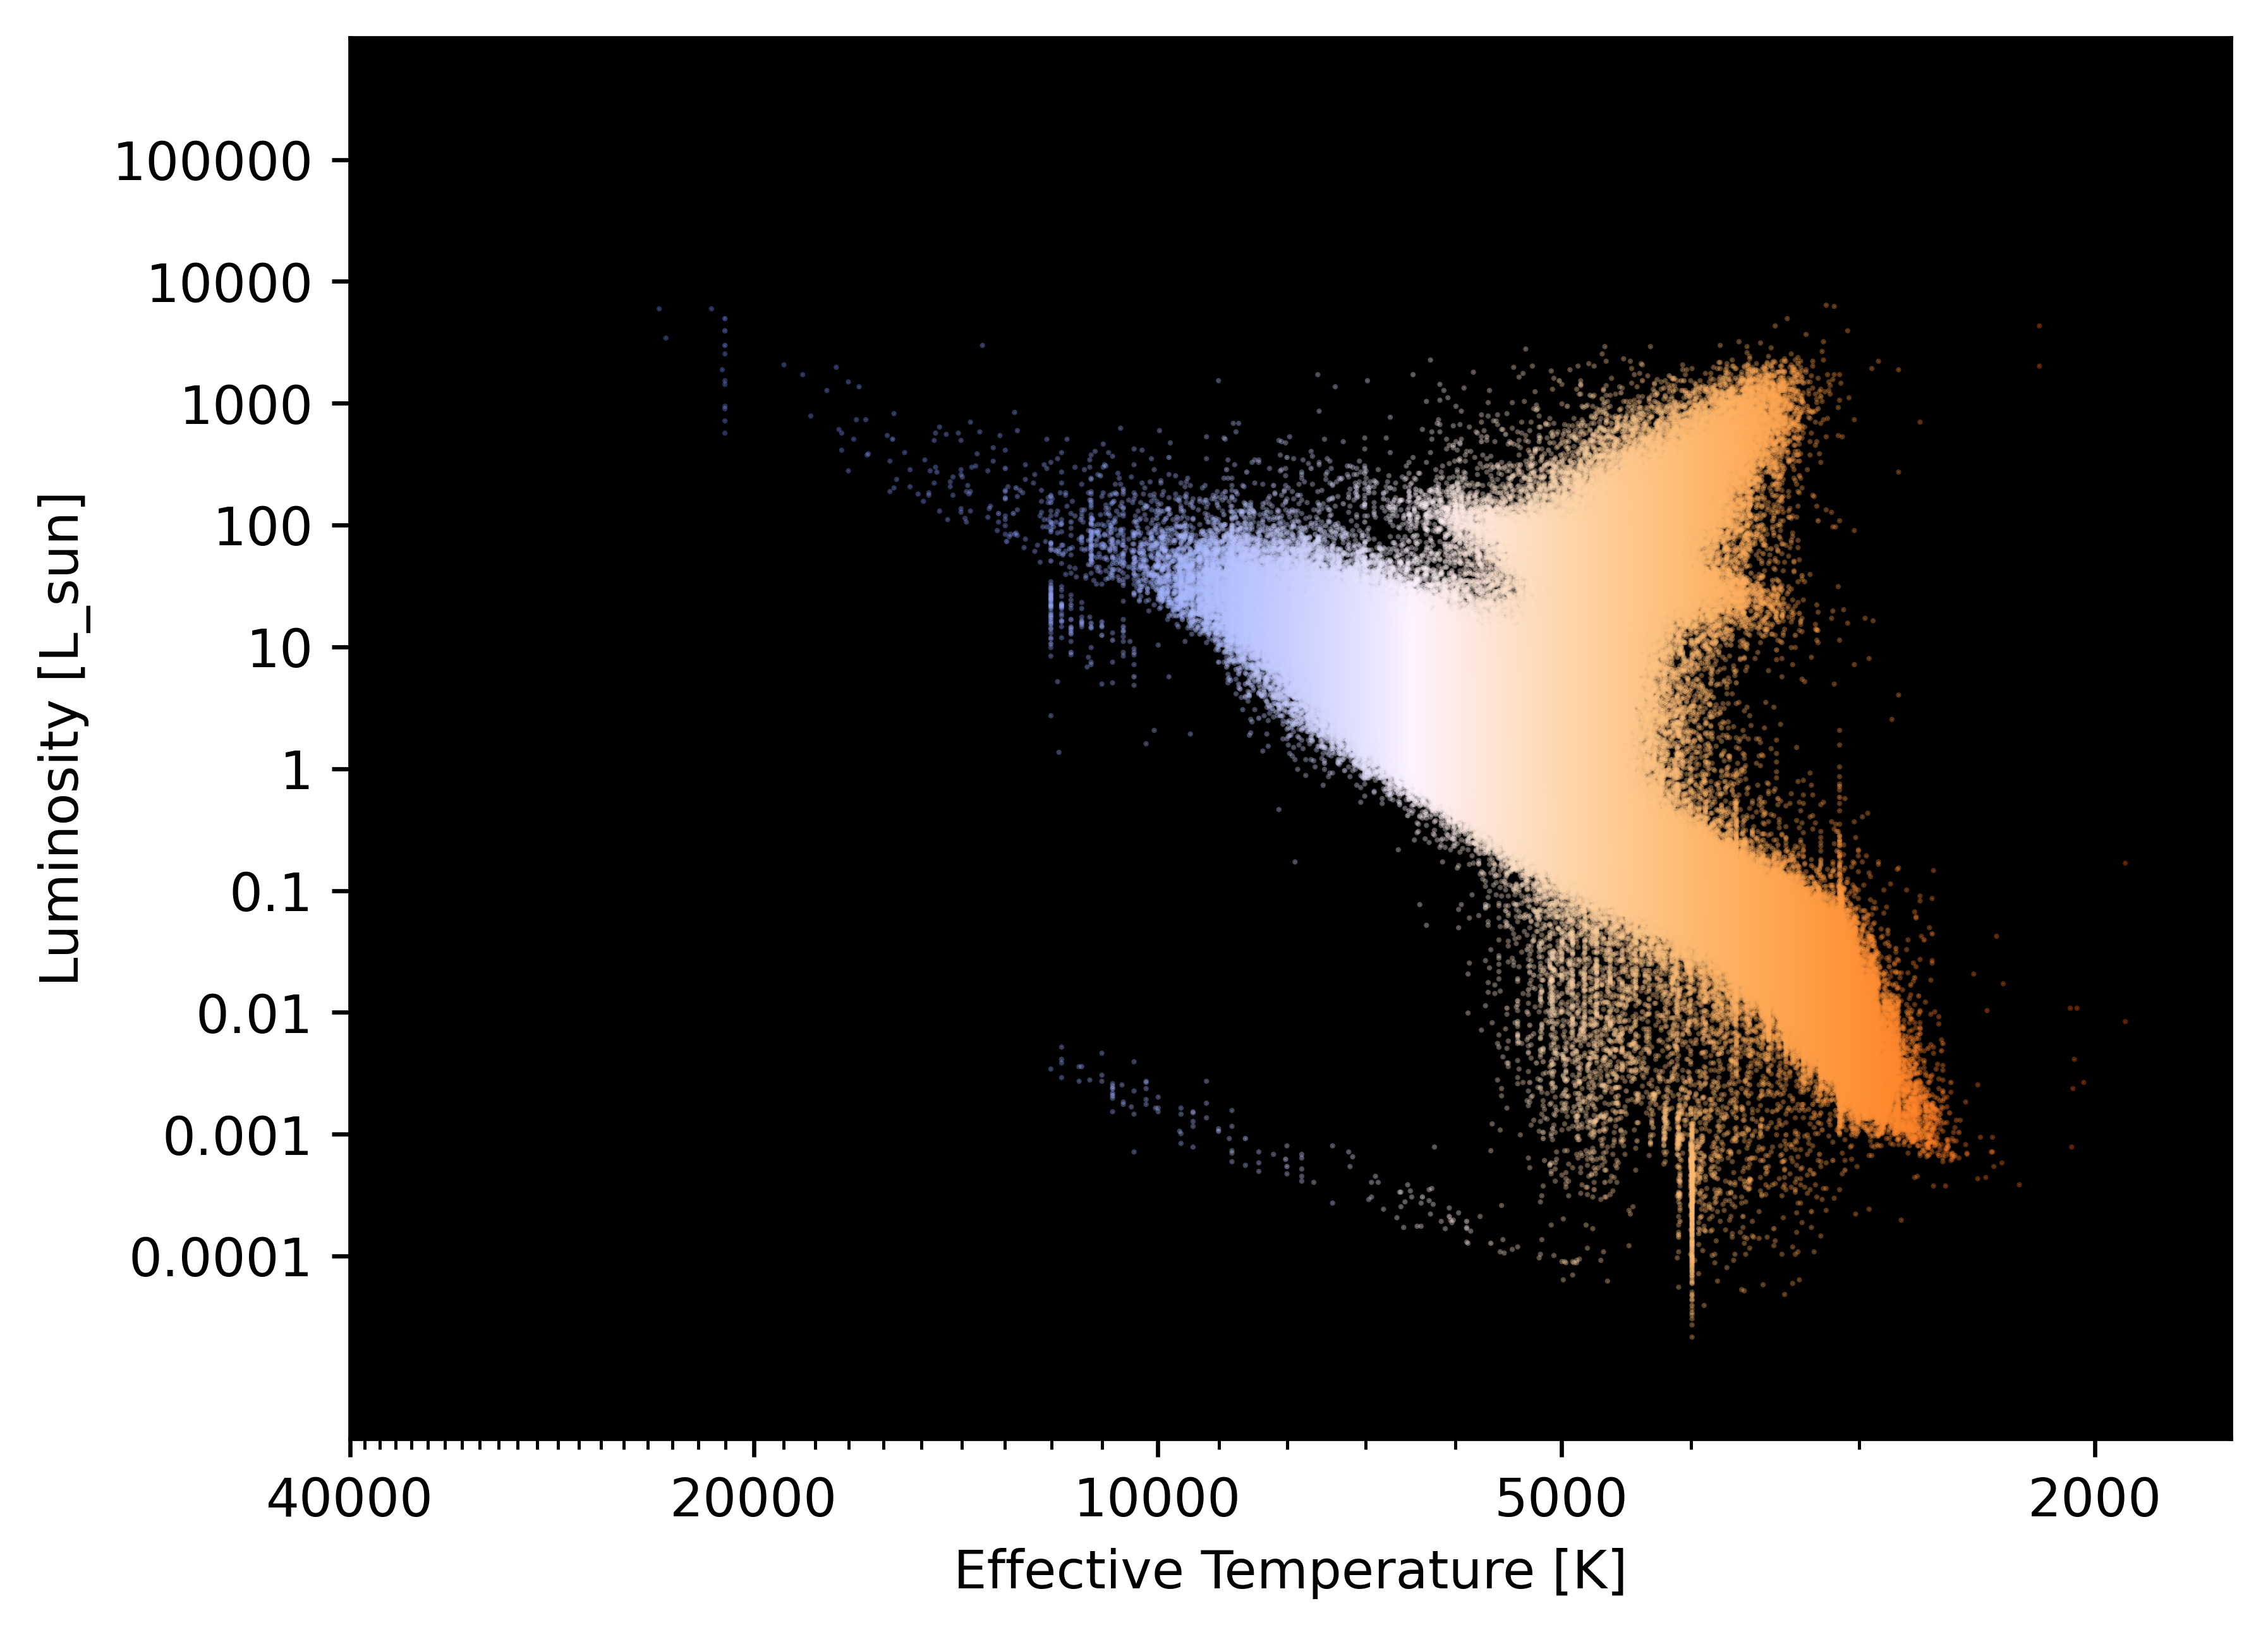

In [7]:
l_points=np.nanmean([xbins[1:],xbins[:-1]],axis=0)
t_points=np.nanmean([ybins[1:],ybins[:-1]],axis=0)
rgb_bins=[]
for i in t_points:
    # T = 500 to 12000 K
    T = np.power(10,i)
    #print(T)
    # Calculate the black body spectrum and the HTML hex RGB colour string
    # it looks like
    spec = planck(T)
    html_rgb = cs.spec_to_rgb(spec, out_fmt='html')
    rgb_bins.append(html_rgb)
#nx=math.ceil((xmax-xmin)*1000) #rounding error don't know why??
#ny=int((ymax-ymin)*100)
plt.figure(dpi=600)
plt.style.use('default')
ax=plt.subplot()
cmap_red_cut = cmr.get_sub_cmap('twilight', 0.6, 1)
counts,ybins,xbins,image=plt.hist2d(logx,logy,norm='log',range=[[xmin,xmax], [ymin,ymax]],bins=[nx,ny],cmap=plt.cm.Greys_r)
ax.invert_xaxis()
ax.set_facecolor('k') 

logcounts=np.log10(counts)/np.log10(np.nanmax(counts))
logcounts=np.where(np.isfinite(logcounts),logcounts,0)


ax.set_xlabel('Effective Temperature [K]')
ax.set_ylabel('Luminosity [L_sun]')
#cbar=plt.colorbar(image,fraction=0.0475, pad=0.005)
#cbar.ax.set_ylabel('n_stars')
x_majorticks=[2000,5000,10000,20000,40000]
x_minorticks_log=np.log10(np.arange(2000,40000,1000))
x_majorticks_log=np.log10(x_majorticks)
ax.set_xticks(x_majorticks_log,labels=x_majorticks)
ax.set_xticks(x_minorticks_log,minor=True)

y_majorticks=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
y_majorticks_log=np.log10(y_majorticks)
ax.set_yticks(y_majorticks_log,labels=y_majorticks)

#kernel = Gaussian2DKernel(x_stddev=4)
#smoothed=convolve(counts,kernel).T
#plt.contour(np.nanmean([ybins[1:],ybins[:-1]],axis=0),np.nanmean([xbins[1:],xbins[:-1]],axis=0),smoothed,levels=[0.25,0.5,1,2,4,8,16,32,64,128],colors='grey',linewidths=0.2)
for i in range(0,len(t_points)):
    t=t_points[i]
    colours=rgb_bins[i]
    #print(colours)
    plt.scatter(t*np.ones(shape=l_points.shape),l_points,color=colours,alpha=np.sqrt(logcounts[i,:]),s=1,edgecolors='None')
plt.show()    

In [8]:
print(len(np.unique(xarr)),len(xarr))

2273929 27520013


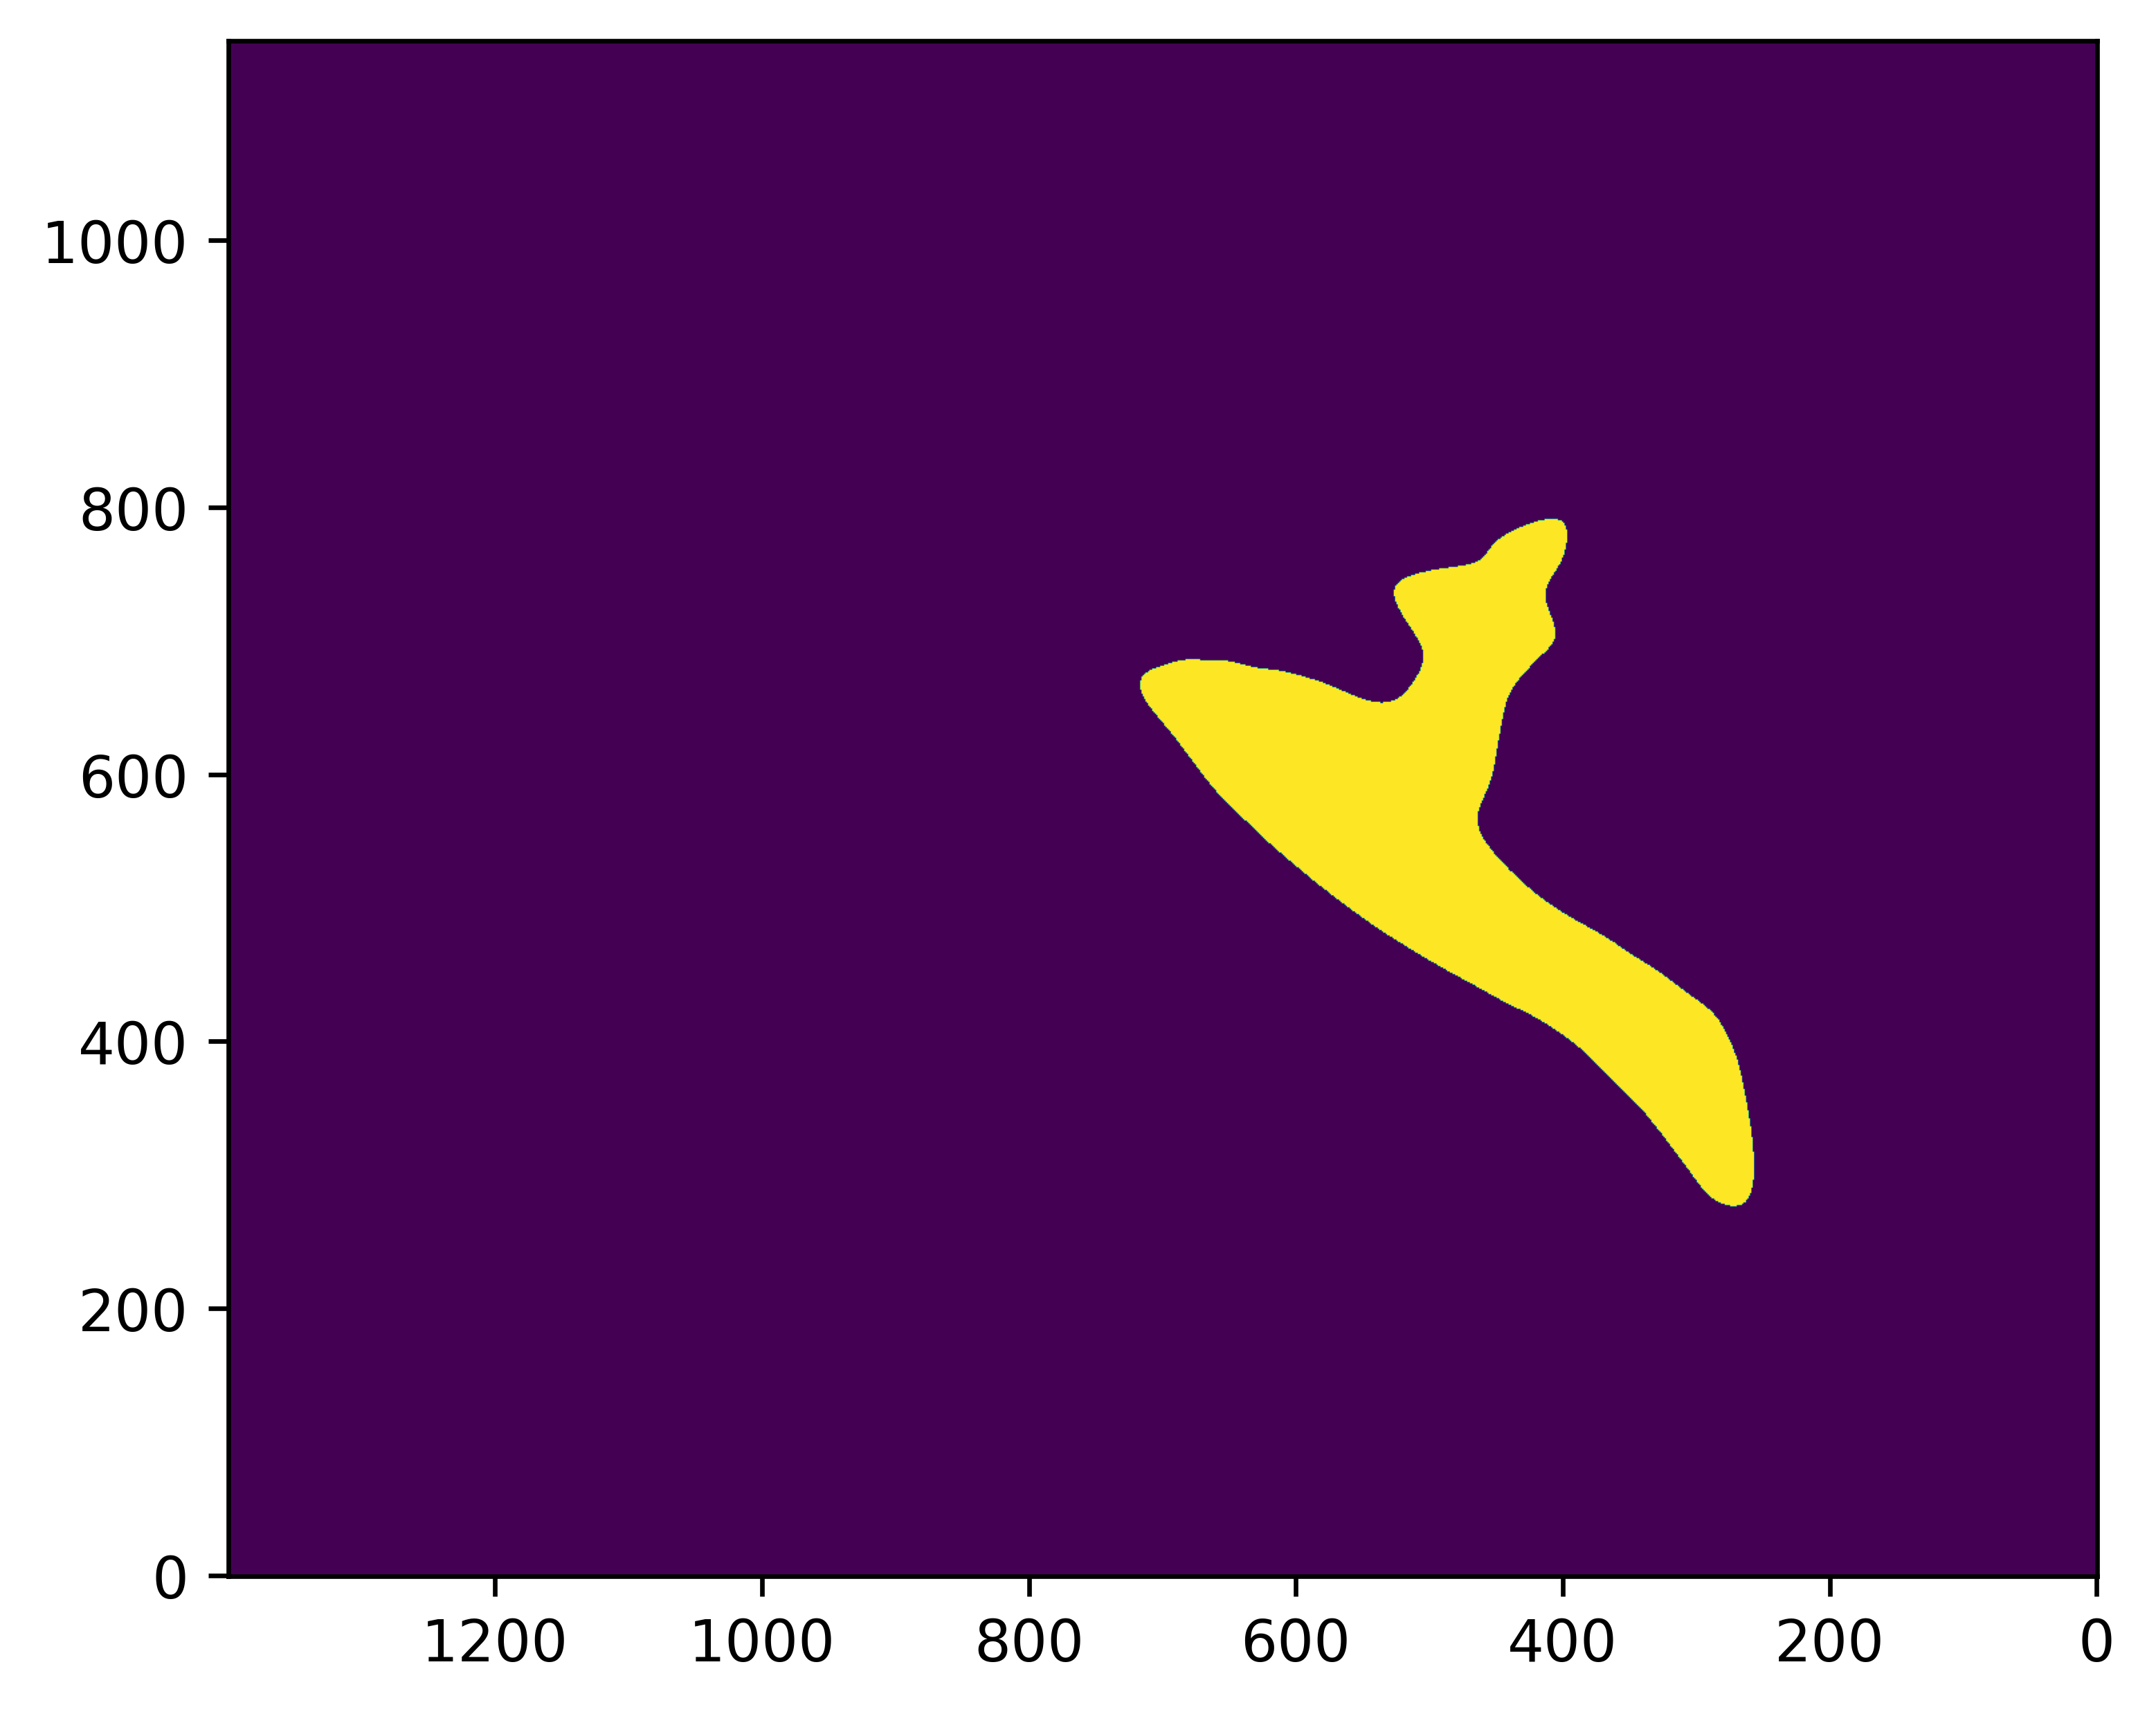

In [9]:
line=np.where(smoothed>=5,1,0)
plt.figure(dpi=600)
ax=plt.subplot()
plt.imshow(line,origin='lower')
ax.invert_xaxis()
plt.show()

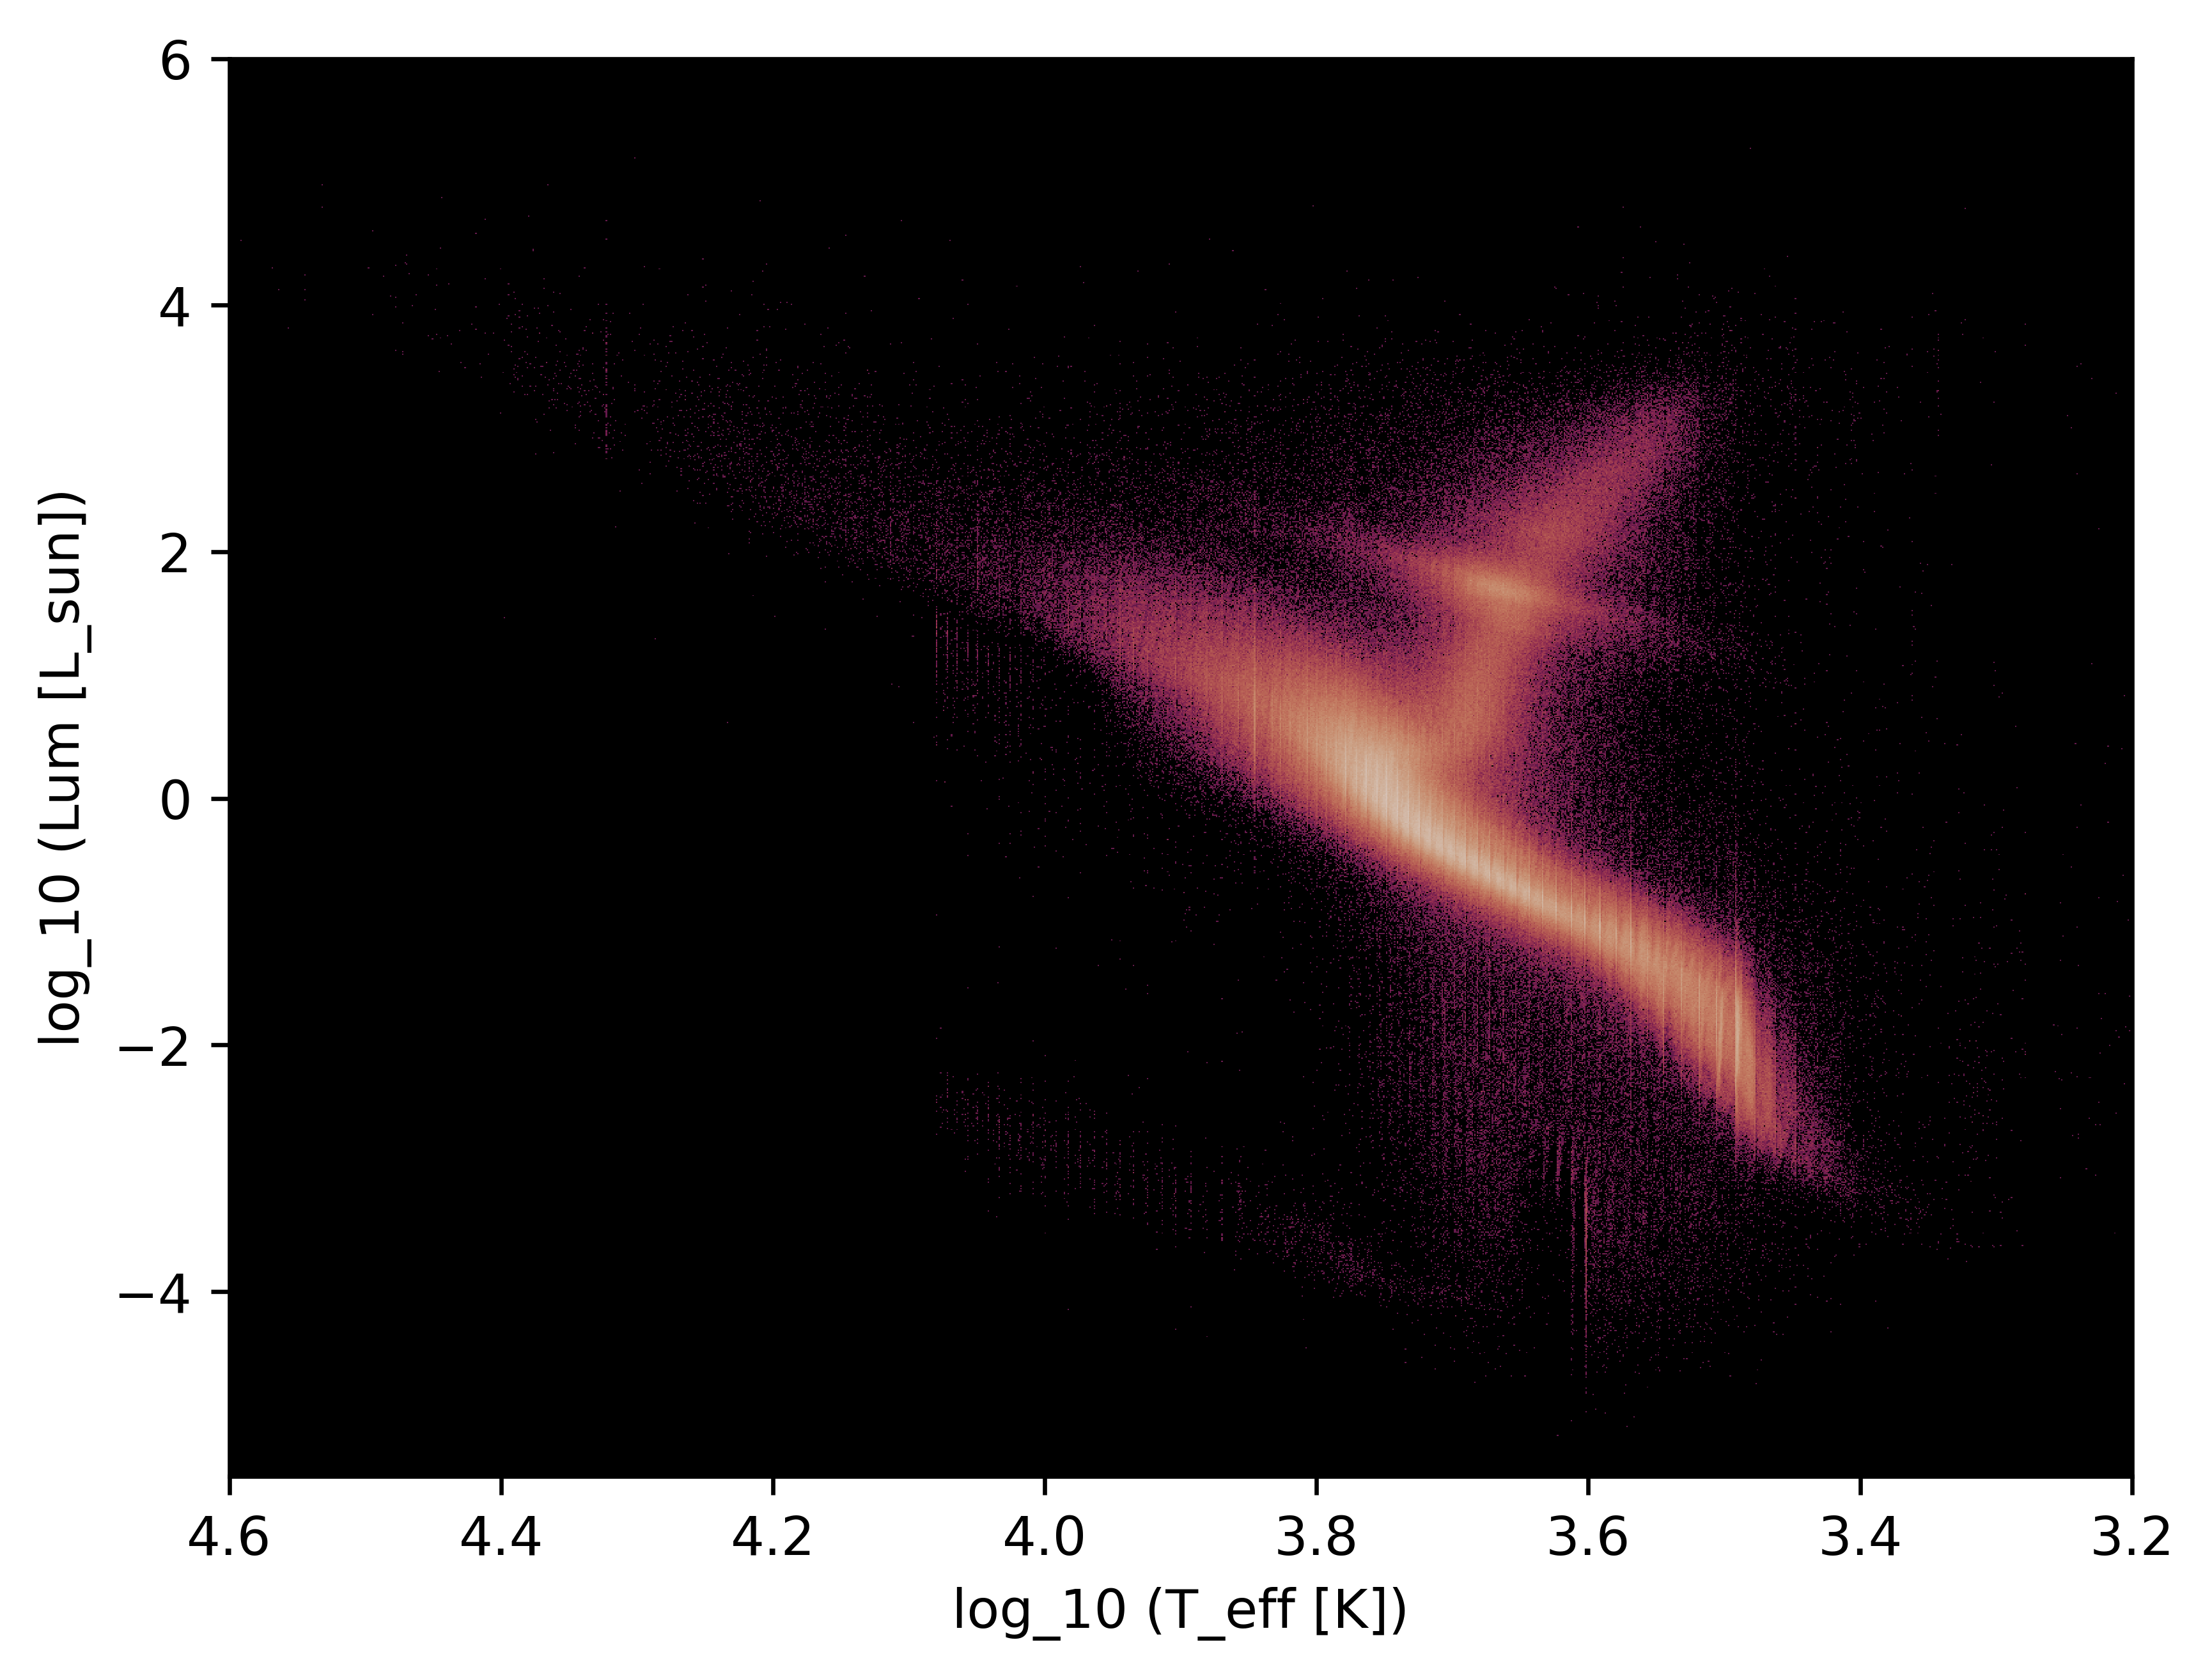

In [10]:
plt.figure(dpi=600)
plt.style.use('default')
ax=plt.subplot()
cmap_red_cut = cmr.get_sub_cmap('twilight', 0.6, 1)
counts,ybins,xbins,image=plt.hist2d(logx,logy,norm='log',range=[[xmin,xmax], [ymin,ymax]],bins=[nx,ny],cmap=cmap_red_cut,vmax=1000)
ax.invert_xaxis()
ax.set_facecolor('k') 


ax.set_xlabel('log_10 (T_eff [K])')
ax.set_ylabel('log_10 (Lum [L_sun])')
#plt.plot(T_fit,L_fit,color='blue')
#plt.plot(T_fit,L_fit+5*sig,color='lightblue')
#plt.plot(T_fit,L_fit-5*sig,color='lightblue')
plt.show()

/home/ela/miniconda3/envs/jupyterenv3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


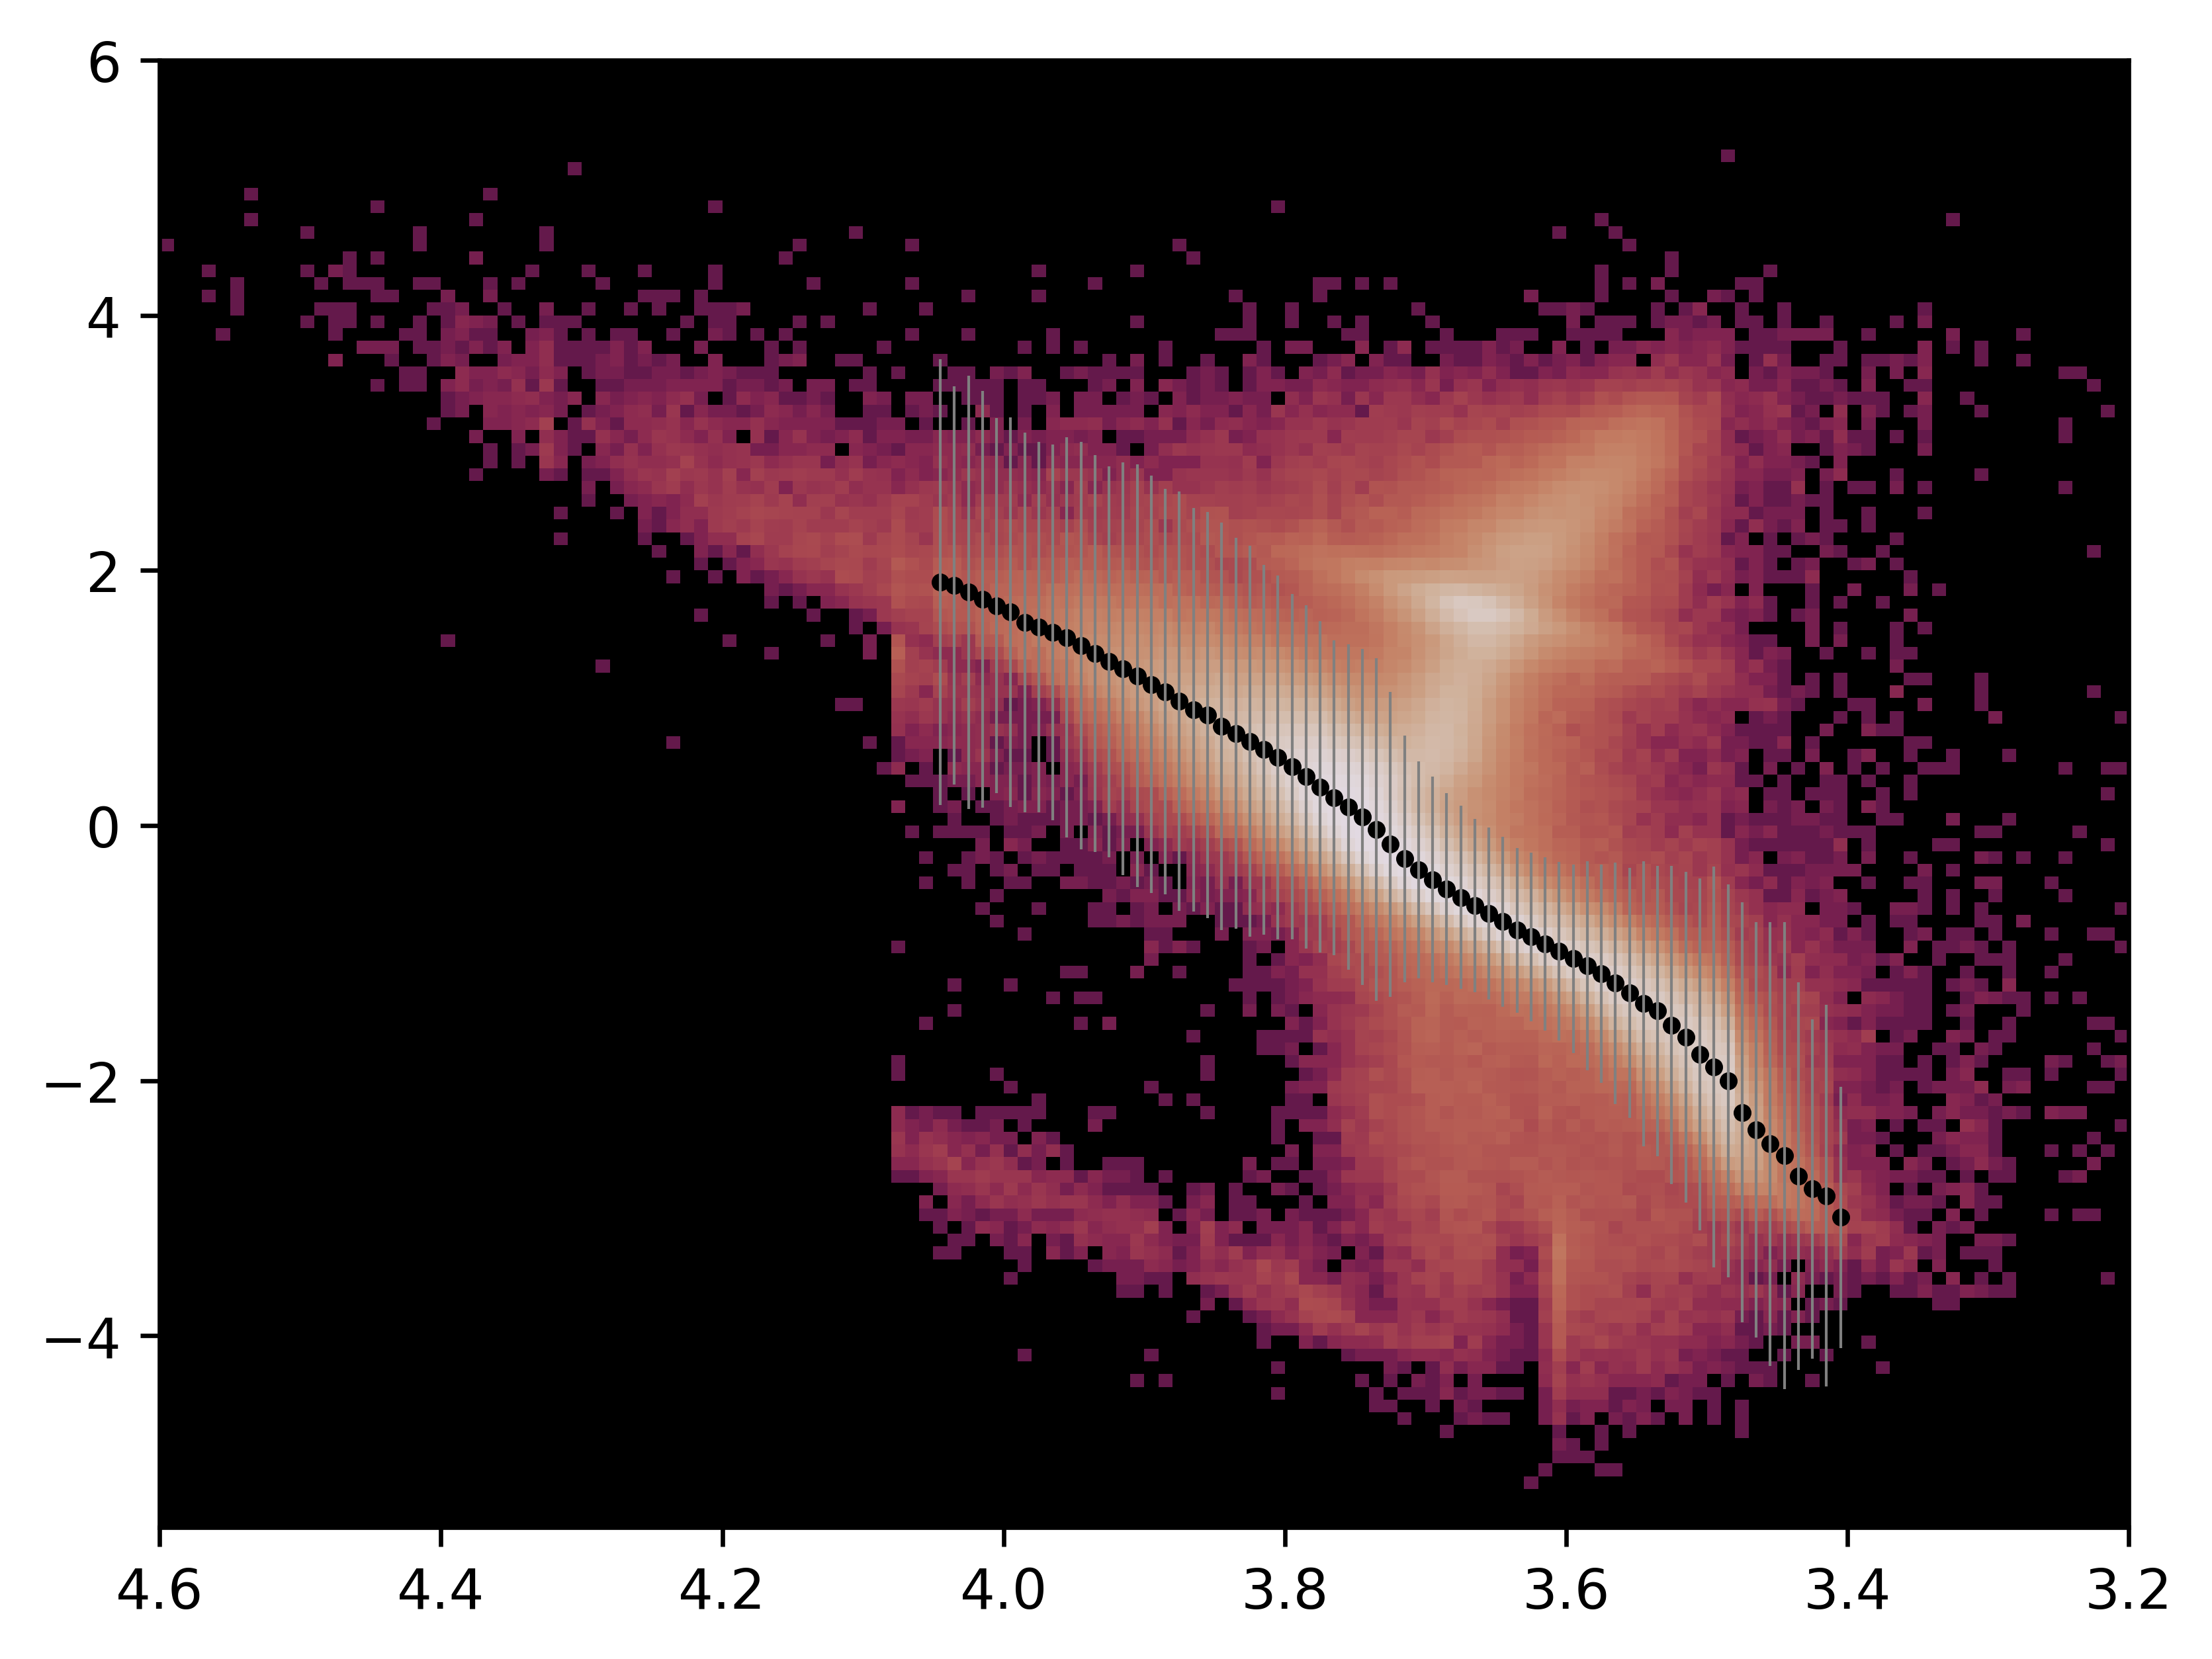

In [14]:
xmin=3.2
xmax=4.6
ymin=-5.5
ymax=6
nx=math.ceil((xmax-xmin)*100) #rounding error don't know why??
ny=int((ymax-ymin)*10)

n = ny                         #the number of data


def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

plt.figure(dpi=600)
plt.style.use('default')
ax=plt.subplot()
cmap_red_cut = cmr.get_sub_cmap('twilight', 0.6, 1)
counts,ybins,xbins,image=plt.hist2d(logx,logy,norm='log',range=[[xmin,xmax], [ymin,ymax]],bins=[nx,ny],cmap=cmap_red_cut)
ax.invert_xaxis()
ax.set_facecolor('k') 

x_tofit=np.nanmean([xbins[1:],xbins[:-1]],axis=0)
y_tofit=np.nanmean([ybins[1:],ybins[:-1]],axis=0)

T_fit=[]
L_fit=[]
L_sig=[]

for i in range(0,ny):
    data=counts[i,:]
    mean = 0       
    sigma = 0.1 
    popt,pcov = curve_fit(gaus,x_tofit,data,p0=[1,mean,sigma])
    #plt.plot(x_tofit,data,'b+:',label='data')
    #plt.plot(x_tofit,gaus(x_tofit,*popt),'ro:',label='fit')
    #print(popt)
    amp,x0,sig=popt
    if np.abs(x0)>=0.001 and y_tofit[i]<=4.05 and y_tofit[i]>=3.4:
        plt.scatter(y_tofit[i],x0,color='black',s=5)
        plt.errorbar(y_tofit[i],x0,5*np.abs(sig),color='grey',lw=0.5)
        T_fit.append(y_tofit[i])
        L_fit.append(x0)
        L_sig.append(sig)

T_fit=np.array(T_fit)
L_fit=np.array(L_fit)
L_sig=np.array(L_sig)

plt.show()

In [15]:
upper=L_fit+5*sig
lower=L_fit-5*sig
upper_fit=np.polyfit(T_fit[40:], upper[40:], 1, cov=False)
lower_fit=np.polyfit(T_fit[40:], lower[40:], 1, cov=False)

upper_line=np.multiply(upper_fit[0],T_fit[20:]) + upper_fit[1]
lower_line=np.multiply(lower_fit[0],T_fit[20:]) + lower_fit[1]

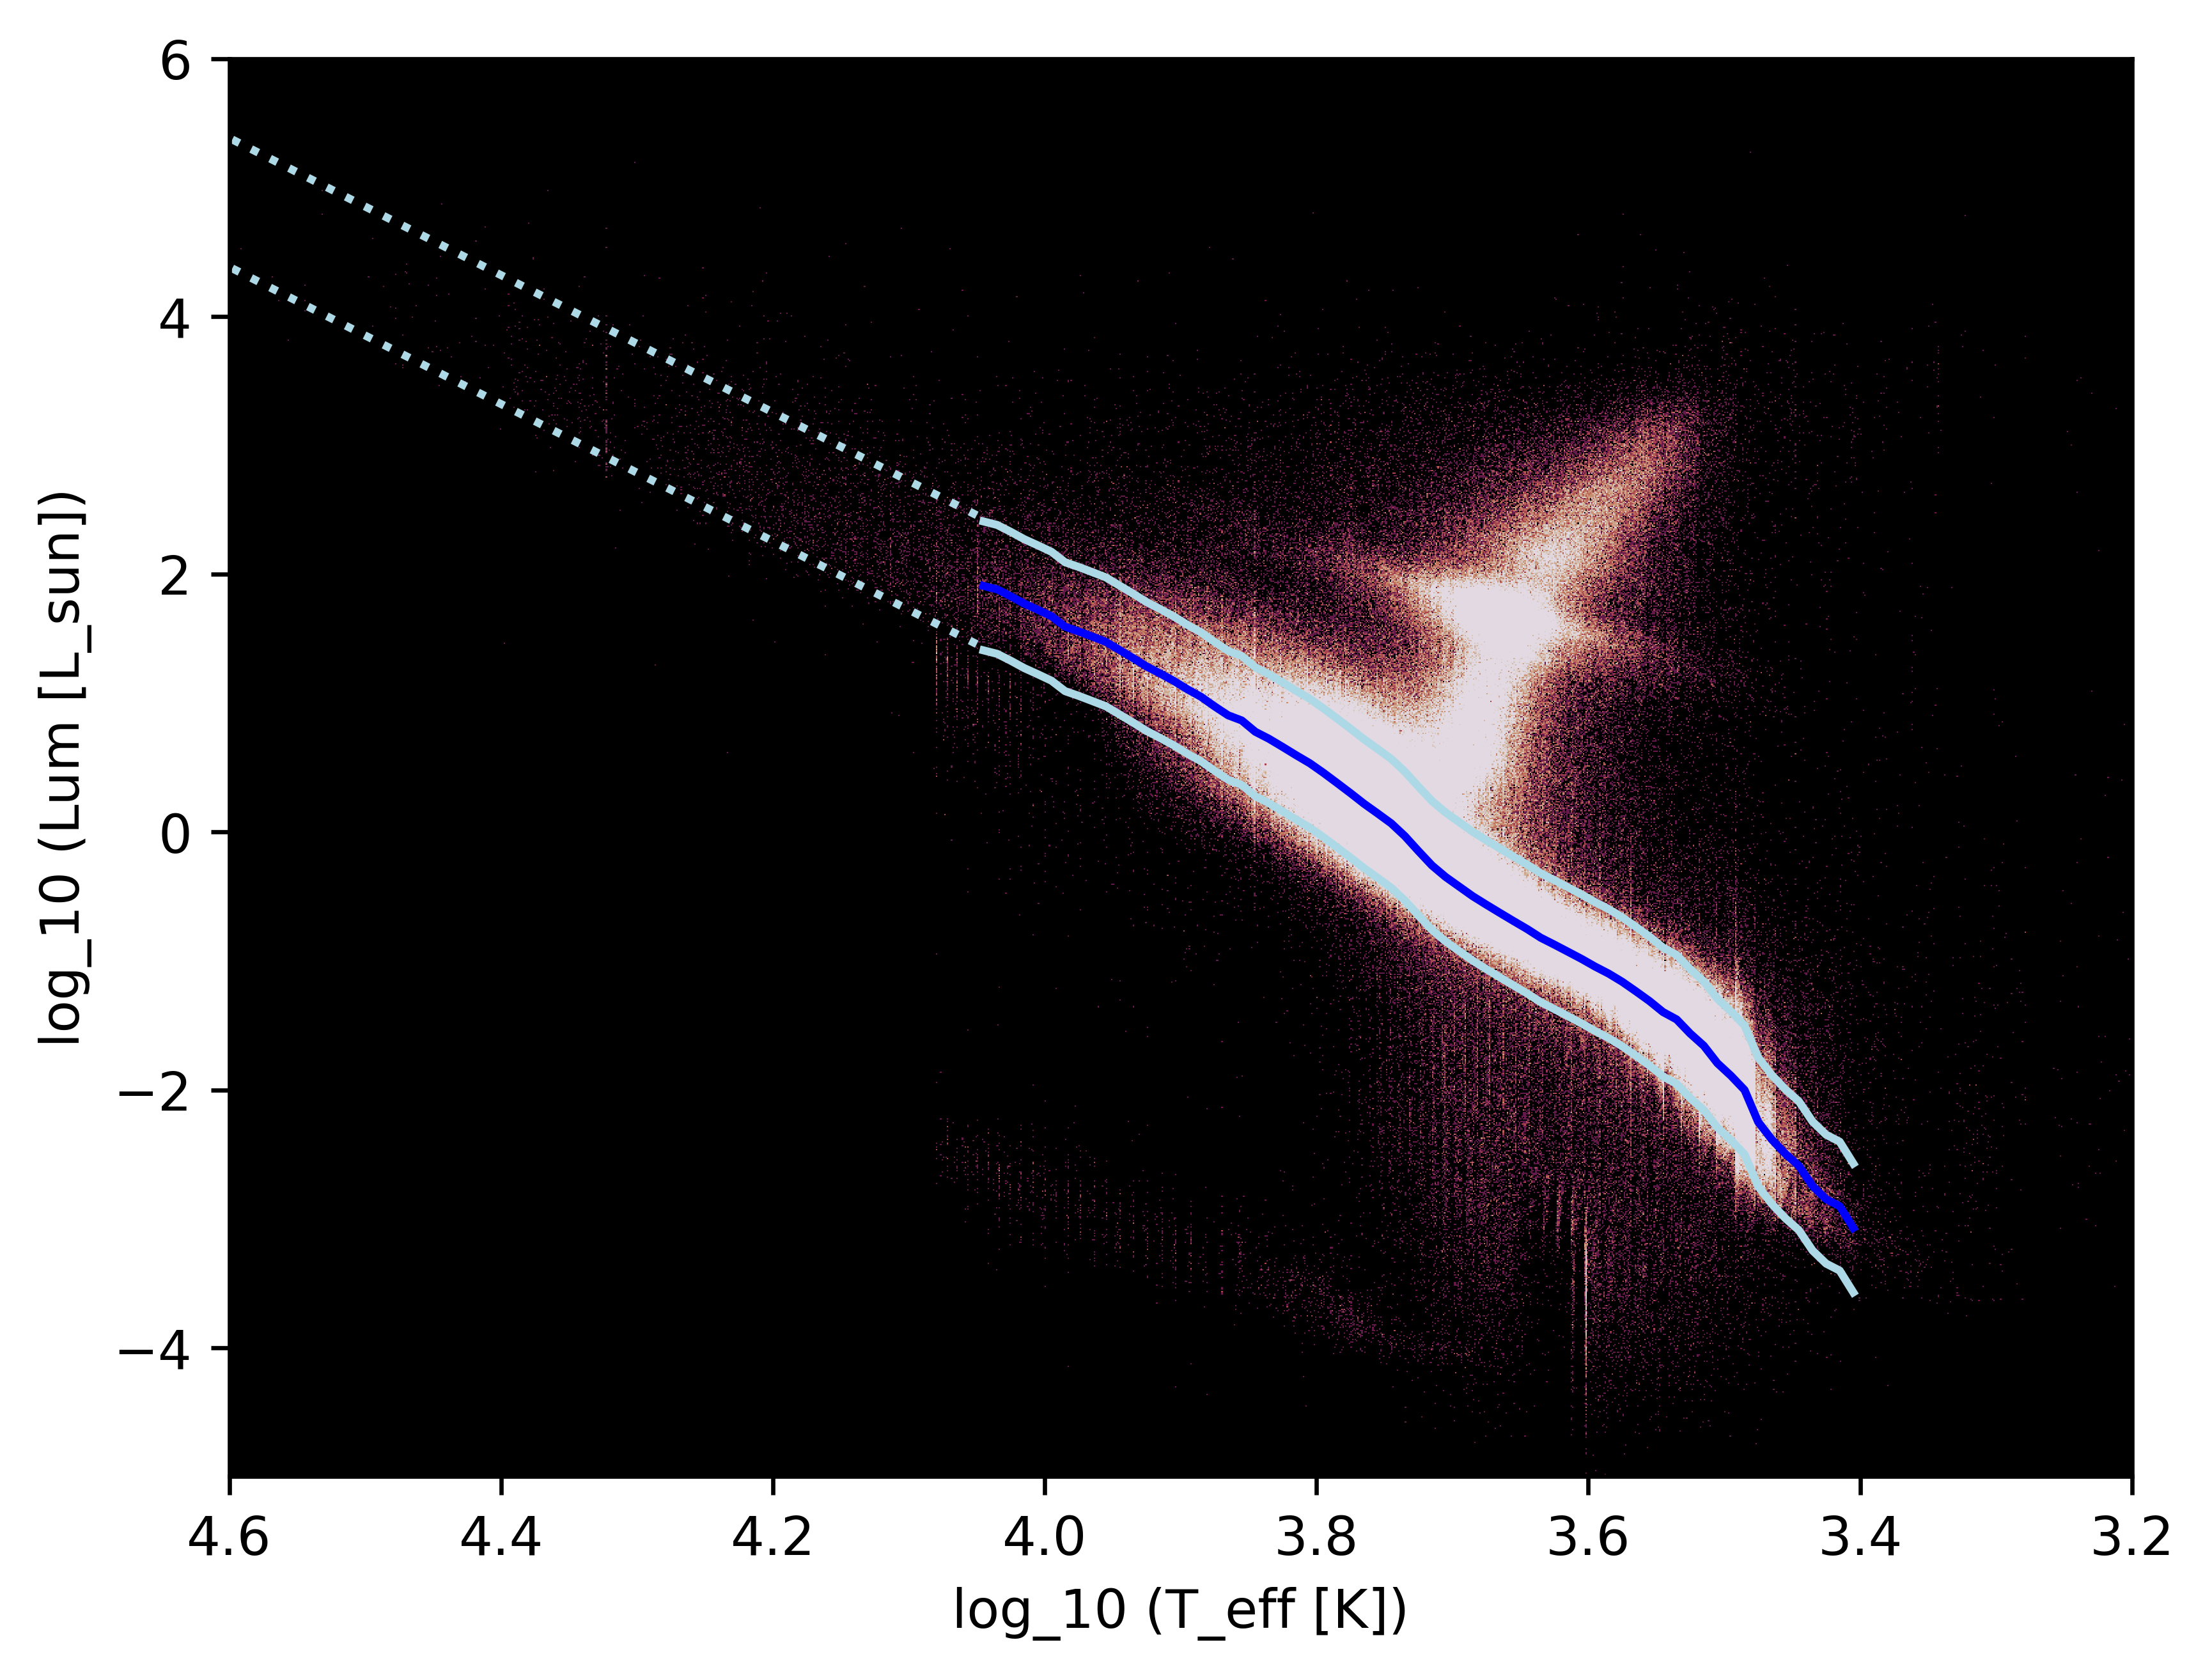

In [16]:
xmin=3.2
xmax=4.6
ymin=-5
ymax=6
nx=math.ceil((xmax-xmin)*1000) #rounding error don't know why??
ny=int((ymax-ymin)*100)
 

plt.figure(dpi=600)
plt.style.use('default')
ax=plt.subplot()
cmap_red_cut = cmr.get_sub_cmap('twilight', 0.6, 1)
counts,ybins,xbins,image=plt.hist2d(logx,logy,norm='log',range=[[xmin,xmax], [ymin,ymax]],bins=[nx,ny],cmap=cmap_red_cut,vmax=10)
ax.invert_xaxis()
ax.set_facecolor('k') 
#for age in logAge:
#    if age%0.5 == 0.0 or age ==10.00001:
#        if age ==10.00001:
#            age=10.0 #dunno why    
#        colour=(age-minage)/(maxage-minage)
#        #print(c)
#        iso_a=np.where(iso[:,2]==age,1,np.nan)
#        iso_b=np.where(iso[:,6]>=-5,iso_a,np.nan) #bad iso values
#        plt.plot(iso_b[:]*iso[:,7],iso_b[:]*iso[:,6],color=cmap_blue(colour),lw=0.8,zorder=5,label=str(age))
#plt.legend(title='logAge')

ax.set_xlabel('log_10 (T_eff [K])')
ax.set_ylabel('log_10 (Lum [L_sun])')
#cbar=plt.colorbar(image,fraction=0.0475, pad=0.005)
#cbar.ax.set_ylabel('n_stars')

#kernel = Gaussian2DKernel(x_stddev=4)
#smoothed=convolve(counts,kernel).T
#plt.contour(np.nanmean([ybins[1:],ybins[:-1]],axis=0),np.nanmean([xbins[1:],xbins[:-1]],axis=0),smoothed,levels=[0.25,0.5,1,2,4,8,16,32,64,128],colors='grey',linewidths=0.2)
plt.plot(T_fit,L_fit,color='blue')
plt.plot(T_fit,L_fit+5*sig,color='lightblue')
plt.plot(T_fit,L_fit-5*sig,color='lightblue')

upper=L_fit+5*sig
lower=L_fit-5*sig
upper_fit=np.polyfit(T_fit[50:], upper[50:], 1, cov=False)
lower_fit=np.polyfit(T_fit[50:], lower[50:], 1, cov=False)

lim_plot=ybins[ybins>=4.05]
upper_line=np.multiply(upper_fit[0],lim_plot) + upper_fit[1]
lower_line=np.multiply(lower_fit[0],lim_plot) + lower_fit[1]

plt.plot(lim_plot,upper_line,color='lightblue',linestyle=':')
plt.plot(lim_plot,lower_line,color='lightblue',linestyle=':')

plt.show()

In [17]:
from scipy import interpolate
x_interp=np.concatenate((T_fit,lim_plot),axis=0)
y_interp_upper=np.concatenate((upper,upper_line),axis=0)
y_interp_lower=np.concatenate((lower,lower_line),axis=0)

#np.save('logT_interp.npy',x_interp)
#np.save('logL_upper.npy',y_interp_upper)
#np.save('logL_lower.npy',y_interp_lower)

In [18]:
logT_interp=np.load('logT_interp.npy')
logL_interp_upper=np.load('logL_upper.npy')
logL_interp_lower=np.load('logL_lower.npy')

f_upper=interpolate.interp1d(x_interp, y_interp_upper)
f_lower=interpolate.interp1d(x_interp, y_interp_lower)

In [70]:
def extract_ms(filelist):
    do_thing=False
    df_list=[]
    n=0
    for file in filelist:
        sub_df = pd.read_table(file,skiprows=1,header=[1,2,3,4,5,6,7],low_memory=False)
        cats = sub_df.select_dtypes(exclude=np.number).columns.tolist()
        #if sub_df.iloc[:,0].astype(str).str.contains("5148000959796332032").any()==True:
            #print(file)
            #
        if "2210.dat" in file:
            do_thing=True
            print("now starting")
        if do_thing==True:
            #features=df.replace('[]', np.nan).replace('--', np.nan)#.select_dtypes(include=numerics)
            T_col=sub_df[('Fitted', 'Teff', 'Value', 'K', '-', '-', '-')]
            L_col=sub_df[('Fitted', 'Lum', 'Value', 'LSun', '-', '-', '-')]
            #print(T,L)
            keep=msq(T_col,L_col)
            for col in cats:
                sub_df[col] = sub_df[col].astype('category') 
            print("MS for {}: {}/{}".format(file[-25:],np.sum(keep),len(sub_df.index) ))
            new_sub_df=sub_df.loc[keep == 1]
            if n==0:
                running_df=new_sub_df
                n+=1
            else:
                running_df=pd.concat([running_df,new_sub_df])
                running_df.to_csv('temp_file2.csv',sep='\t', index=False, quoting=3,escapechar="\t",na_rep='[]',header=True)

    features=running_df
    features.to_csv(pyssed_file,sep='\t', index=False, quoting=3,escapechar="\t",na_rep='[]',header=True)
    return features

def msq(T,L):
    
    boolarr=np.where(T>0.0,1,0)
    
    logT=boolarr*np.log10(T)
    logL=np.log10(L)

    farr=np.where(logT >=3.405,1,np.nan)
    farr=farr*np.where(logT <=4.6,1,np.nan)

    logL_upper=f_upper(farr*logT)
    logL_lower=f_lower(farr*logT)
    boolarr=boolarr*np.where(logT >=3.405,1,0)
    boolarr=boolarr*np.where(logL <= logL_upper,1,0)
    boolarr=boolarr*np.where(logL >= logL_lower,1,0)

    return boolarr   

In [ ]:
import warnings
warnings.filterwarnings("ignore")
df=extract_ms(filelist)
#T_col=df[('Fitted', 'Teff', 'Value', 'K', '-', '-', '-')]
#L_col=df[('Fitted', 'Lum', 'Value', 'LSun', '-', '-', '-')]
#plt.figure()
#ax=plt.subplot()
#ax.scatter(T_col,L_col,alpha=0.2,facecolor='k',s=0.5,edgecolor='None')
#ax.invert_xaxis()
#ax.set_xscale('log')
#ax.set_yscale('log')
#plt.savefig('ms_test.png')
#plt.show()

now starting
MS for batch1/output_run2210.dat: 31/84
MS for batch1/output_run2211.dat: 199/1979
MS for batch1/output_run2212.dat: 19/75
MS for batch1/output_run2213.dat: 84/1028
MS for batch1/output_run2214.dat: 17/89
MS for batch1/output_run2215.dat: 80/634
MS for batch1/output_run2216.dat: 46/127
MS for batch1/output_run2217.dat: 63/206
MS for batch1/output_run2218.dat: 49/190
MS for batch1/output_run2219.dat: 24/208
MS for _batch1/output_run221.dat: 137/3820
MS for batch1/output_run2220.dat: 44/195
MS for batch1/output_run2221.dat: 26/104
MS for batch1/output_run2222.dat: 272/9584
MS for batch1/output_run2223.dat: 87/527
MS for batch1/output_run2224.dat: 79/355
MS for batch1/output_run2225.dat: 152/2285
MS for batch1/output_run2226.dat: 65/379
MS for batch1/output_run2227.dat: 28/107
MS for batch1/output_run2228.dat: 19/74
MS for batch1/output_run2229.dat: 237/4473
MS for _batch1/output_run222.dat: 22/95
MS for batch1/output_run2230.dat: 15/104
MS for batch1/output_run2231.dat: 126/